In [27]:
import pandas as pd
import re

def import_csv_file(file_path):
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip')
        # delete unnecessary columns
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"✅ データファイル '{file_path}' を正常に読み込みました。")
        return df
    except FileNotFoundError:
        print(f"❌ エラー: ファイルが見つかりません。パスを確認してください: '{file_path}'")
        return None

In [37]:
def parse_triangle_accuracy(df: pd.DataFrame) -> list:
    accuracy_matrix = []
    current_list = []
    previous_seed = -1  # 初期値を -1 にしておく

    for _, row in df.iterrows():
        seed = int(row['dataset_seed'])  # ここで数値化
        acc = row['テスト精度 (Test Acc)']

        if previous_seed != -1 and seed == 0:
            # dataset_seed が 0 に戻る = 新しい訓練ステップの開始
            accuracy_matrix.append(current_list)
            current_list = [acc]
        else:
            current_list.append(acc)

        previous_seed = seed

    # 最後の current_list を追加
    if current_list:
        accuracy_matrix.append(current_list)

    return accuracy_matrix


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def get_color_and_linestyle(batch_size, mem):
    # バッチサイズの色（暖色/寒色）
    batch_colors = {
        0: 'tab:green',    
        8: 'tab:red',      
        32: 'tab:orange',
        128: 'tab:blue',  
    }

    mem_linestyle_map = {
        0: '-',           
        500: '--',
        3000: '-.',
        5000: '-'
    }

    # 色設定
    color = batch_colors.get(batch_size, 'black')  # 未定義のバッチサイズは黒

    # 線種設定
    try:
        mem_int = int(mem)
        linestyle = mem_linestyle_map.get(mem_int, ':')  # 未定義のmemは破線（:）
    except:
        linestyle = ':'  # memが整数でない場合のfallback

    return color, linestyle


def plot_task0_accuracy_with_style(all_results, csv_list, meta_info, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Task Number")
    plt.ylabel("Test Accuracy on Task0")

    # X軸の最大値を計算（全ての実験で最もタスク数が多いものに合わせる）
    max_tasks = 0
    if all_results:
        max_tasks = max(len(res) for res in all_results)

    # 入力に含まれるmem値とbatch_size値を動的に取得し、昇順で並び替え
    unique_mem = sorted(set(info['mem'] for info in meta_info))
    unique_bs = sorted(set(info['batch_size'] for info in meta_info))

    # mem優先で並び替え（memが外側、bsが内側ループ）
    ordered_combinations = [(mem, bs) for mem in unique_mem for bs in unique_bs]

    for mem, bs in ordered_combinations:
        for i, info in enumerate(meta_info):
            if info['mem'] == mem and info['batch_size'] == bs:
                result_matrix = all_results[i]
                label = csv_list[i]
                color, linestyle = get_color_and_linestyle(bs, mem)

                y_values = [row[0] if len(row) > 0 else None for row in result_matrix]
                x_values = list(range(len(y_values)))

                plt.plot(
                    x_values,
                    y_values,
                    label=f"mem:{mem}, bs:{bs}",
                    color=color,
                    linestyle=linestyle
                )

    # --- ▼▼▼ ここを修正 ▼▼▼ ---
    # X軸の目盛りを0から最大タスク数まで、全ての整数で表示するように設定
    if max_tasks > 0:
        plt.xticks(range(max_tasks))
    # --- ▲▲▲ 修正はここまで ▲▲▲ ---

    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_own_task_accuracy_with_style(all_results, csv_list, meta_info, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Task Number")
    plt.ylabel("Test Accuracy on Own Task")

    # X軸の最大値を計算
    max_tasks = 0
    if all_results:
        max_tasks = max(len(res) for res in all_results)

    unique_mem = sorted(set(info['mem'] for info in meta_info))
    unique_bs = sorted(set(info['batch_size'] for info in meta_info))
    ordered_combinations = [(mem, bs) for mem in unique_mem for bs in unique_bs]

    for mem, bs in ordered_combinations:
        for i, info in enumerate(meta_info):
            if info['mem'] == mem and info['batch_size'] == bs:
                result_matrix = all_results[i]
                label = csv_list[i]
                color, linestyle = get_color_and_linestyle(bs, mem)

                y_values = []
                for idx, row in enumerate(result_matrix):
                    if len(row) > idx:
                        y_values.append(row[idx])
                    else:
                        y_values.append(None)

                x_values = list(range(len(y_values)))

                plt.plot(
                    x_values,
                    y_values,
                    label=f"mem:{mem}, bs:{bs}",
                    color=color,
                    linestyle=linestyle
                )

    # X軸の目盛りを0から最大タスク数まで、全ての整数で表示するように設定
    if max_tasks > 0:
        plt.xticks(range(max_tasks))

    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Task Number")
    plt.ylabel("Test Accuracy on Own Task")


In [5]:

# 例: CSVファイルのパスリスト
csv_list = ["/work/test/DIL/random_baseline.csv","/work/test/DIL/er_sweep_mem5000_bs8.csv", "/work/test/DIL/er_sweep_mem500_bs8.csv", "/work/test/DIL/er_sweep_mem3000_bs8.csv","/work/test/DIL/er_sweep_mem5000_bs32.csv", "/work/test/DIL/er_sweep_mem500_bs32.csv", "/work/test/DIL/er_sweep_mem3000_bs32.csv","/work/test/DIL/er_sweep_mem5000_bs128.csv", "/work/test/DIL/er_sweep_mem500_bs128.csv", "/work/test/DIL/er_sweep_mem3000_bs128.csv"]
meta_info = [
    {'batch_size': 0, 'mem': 0},
    {'batch_size': 8, 'mem': 5000},
    {'batch_size': 8, 'mem': 500},
    {'batch_size': 8, 'mem': 3000},
    {'batch_size': 32, 'mem': 5000},
    {'batch_size': 32, 'mem': 500},
    {'batch_size': 32, 'mem': 3000},
    {'batch_size': 128, 'mem': 5000},
    {'batch_size': 128, 'mem': 500},
    {'batch_size': 128, 'mem': 3000},
]
all_results = []

print(parse_triangle_accuracy(import_csv_file("/work/test/DIL/random_baseline.csv")))  # ベースラインのCSVを読み込む
for csv_file in csv_list:
    df = import_csv_file(csv_file)
    result = parse_triangle_accuracy(df)
    all_results.append(result)
    
# 各CSVファイルのタスク0のテスト精度をプロット
plot_task0_accuracy_with_style(all_results, csv_list, meta_info, "Accuracy on Task0 per Training Task vs. no Replay")
# 最後に共通グラフを描画
plot_own_task_accuracy_with_style(all_results, csv_list, meta_info, "Accuracy on Own Task per Training Task vs. no Replay")


❌ エラー: ファイルが見つかりません。パスを確認してください: '/work/test/DIL/random_baseline.csv'


AttributeError: 'NoneType' object has no attribute 'dropna'

✅ データファイル '/work/test/DIL/random_baseline.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem5000_bs8.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem500_bs8.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem5000_bs32.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem500_bs32.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem5000_bs128.csv' を正常に読み込みました。
✅ データファイル '/work/test/DIL/er_sweep_mem500_bs128.csv' を正常に読み込みました。


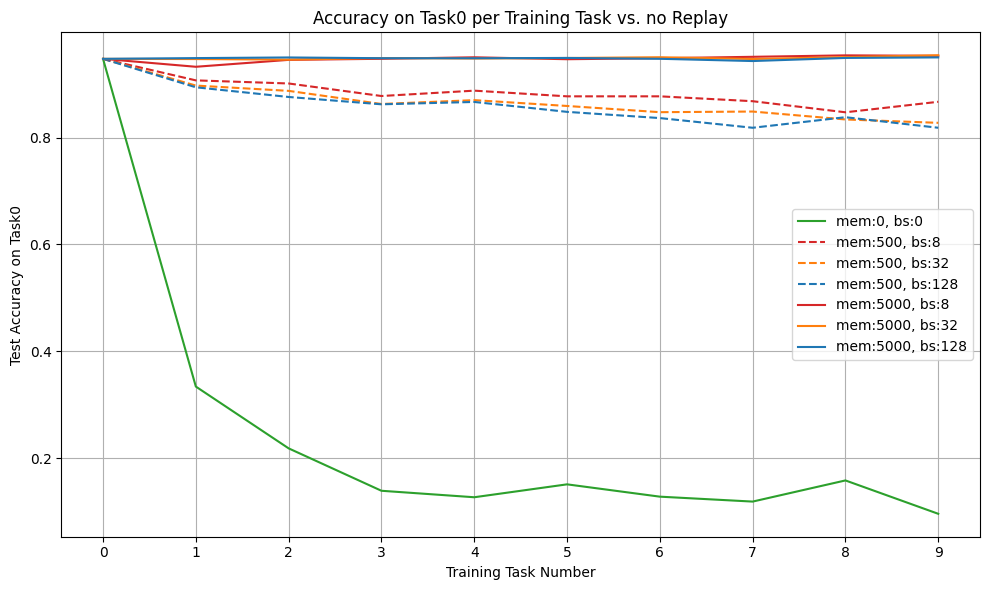

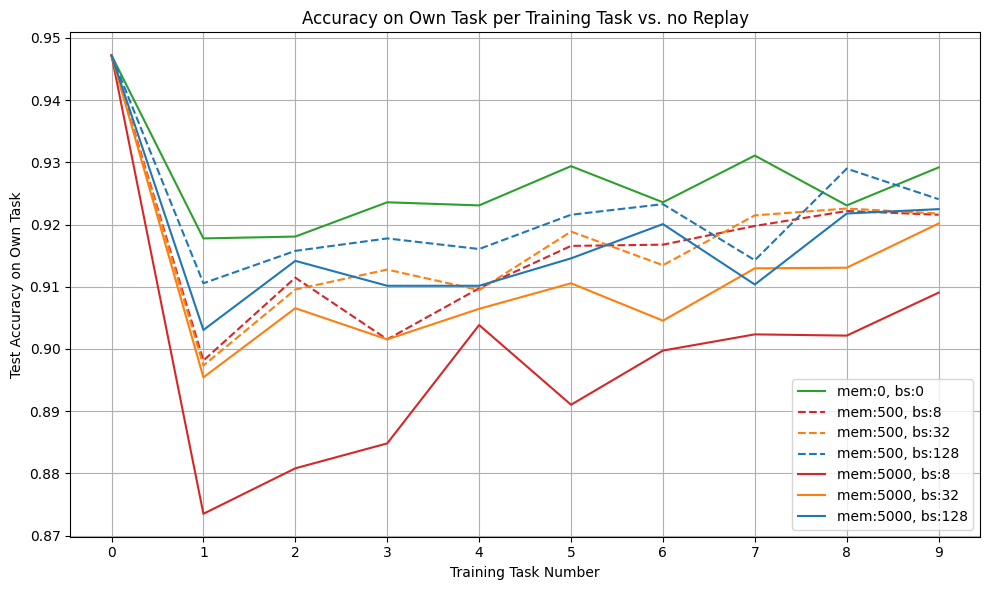

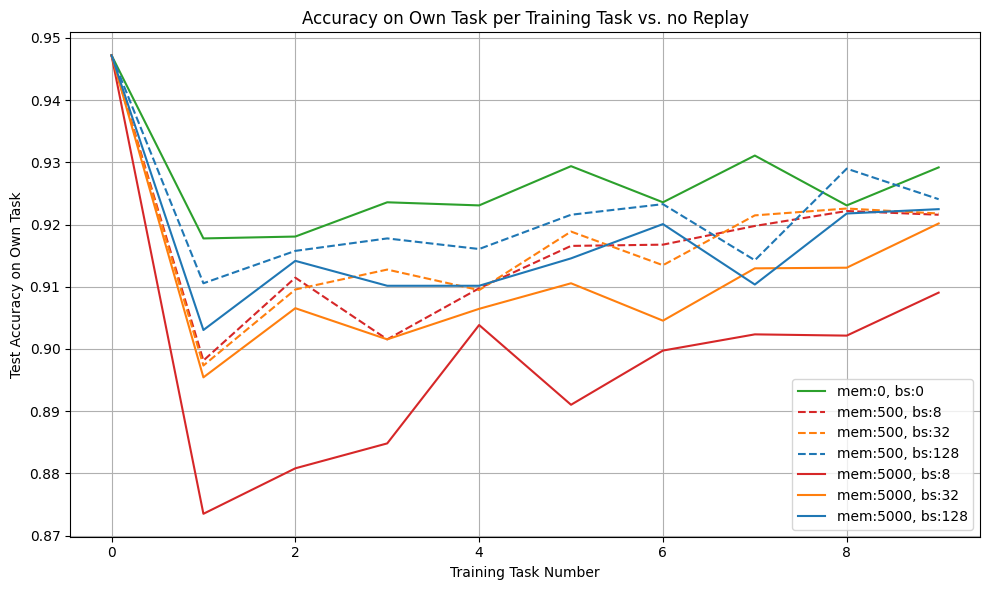

In [ ]:

# 例: CSVファイルのパスリスト
csv_list = ["/work/test/DIL/random_baseline.csv","/work/test/DIL/er_sweep_mem5000_bs8.csv", "/work/test/DIL/er_sweep_mem500_bs8.csv", "/work/test/DIL/er_sweep_mem5000_bs32.csv", "/work/test/DIL/er_sweep_mem500_bs32.csv", "/work/test/DIL/er_sweep_mem5000_bs128.csv", "/work/test/DIL/er_sweep_mem500_bs128.csv"]
meta_info = [
    {'batch_size': 0, 'mem': 0},
    {'batch_size': 8, 'mem': 5000},
    {'batch_size': 8, 'mem': 500},
    {'batch_size': 32, 'mem': 5000},
    {'batch_size': 32, 'mem': 500},
    {'batch_size': 128, 'mem': 5000},
    {'batch_size': 128, 'mem': 500},
]
all_results = []

for csv_file in csv_list:
    df = import_csv_file(csv_file)
    result = parse_triangle_accuracy(df)
    all_results.append(result)
    
# 各CSVファイルのタスク0のテスト精度をプロット
plot_task0_accuracy_with_style(all_results, csv_list, meta_info, "Accuracy on Task0 per Training Task vs. no Replay")
# 最後に共通グラフを描画
plot_own_task_accuracy_with_style(all_results, csv_list, meta_info, "Accuracy on Own Task per Training Task vs. no Replay")


[[0.9472155570983888, 0.3342347741127014, 0.91776841878891, 0.2186498343944549, 0.4834735691547394, 0.9180688858032228, 0.1393229216337204, 0.2220552861690521, 0.3988381326198578, 0.9235777258872986, 0.1272035241127014, 0.2626201808452606, 0.3341346085071563, 0.5232371687889099, 0.9230769276618958, 0.1513421535491943, 0.2256610542535781, 0.1909054517745971, 0.2666265964508056, 0.4689503312110901, 0.9293870329856871, 0.1283052861690521, 0.1773838102817535, 0.1966145783662796, 0.1550480723381042, 0.3066906929016113, 0.5082131624221802, 0.9235777258872986, 0.1190905421972274, 0.1607572138309478, 0.2050280421972274, 0.1771834939718246, 0.1923076957464218, 0.2713341414928436, 0.3719951808452606, 0.9310897588729858, 0.1586538404226303, 0.1750801354646682, 0.1302083283662796, 0.1393229216337204, 0.1248998418450355, 0.1909054517745971, 0.2565104067325592, 0.4477163553237915, 0.9230769276618958, 0.0962540060281753, 0.1482371836900711, 0.1605568975210189, 0.115084134042263, 0.1097756400704383, 0

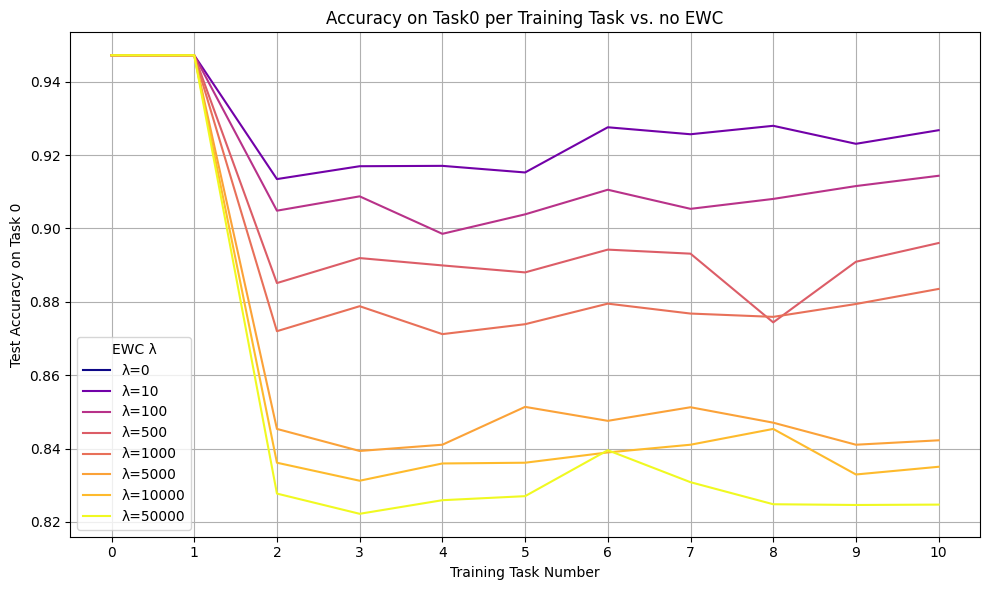

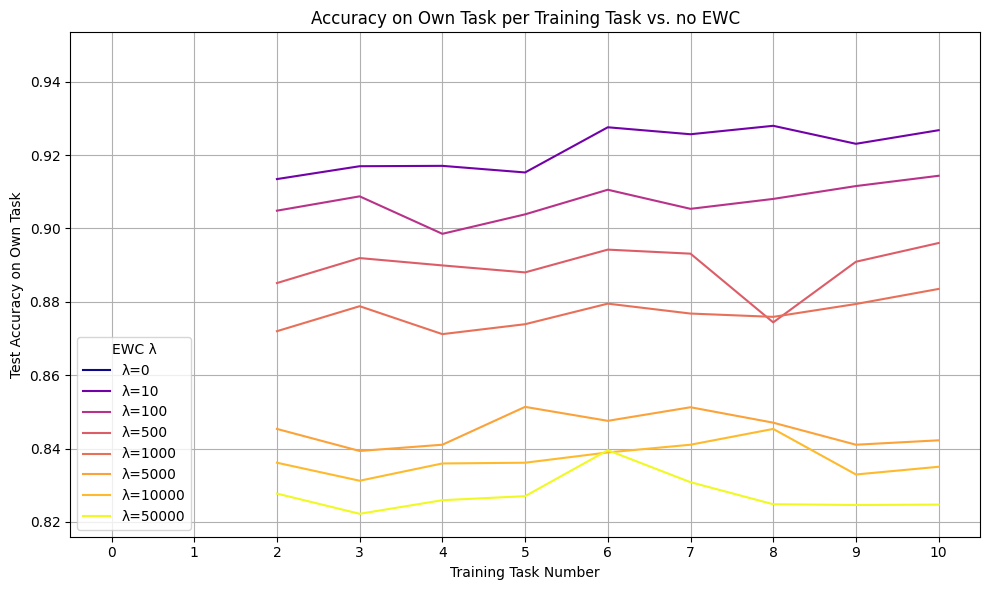

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def get_color_and_linestyle(lambda_value):
    
    # 色は連続カラーマップ (plasma) で表現
    lmbds = [0, 10, 100, 500, 1000, 5000, 10000, 50000]
    norm = (np.log10(lambda_value + 1) - np.log10(1)) / (np.log10(max(lmbds) + 1) - np.log10(1))
    color = cm.plasma(norm)

    return color

def plot_task0_accuracy_with_lambda(all_results, meta_info, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Task Number")
    plt.ylabel("Test Accuracy on Task 0")

    max_tasks = max(len(res) for res in all_results if res)

    unique_lambdas = sorted(set(info['lambda'] for info in meta_info))

    for i, info in enumerate(meta_info):
        lmbd = info['lambda']
        result_matrix = all_results[i]
        print(result_matrix)
        color = get_color_and_linestyle(lmbd)

        y_values = [row[0] if len(row) > 0 else np.nan for row in result_matrix]
        x_values = list(range(len(y_values)))

        plt.plot(
            x_values,
            y_values,
            label=f"λ={lmbd}",
            color=color
        )

    plt.xticks(range(max_tasks))
    plt.legend(title="EWC λ", loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_own_task_accuracy_with_lambda(all_results, meta_info, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Task Number")
    plt.ylabel("Test Accuracy on Own Task")

    max_tasks = max(len(res) for res in all_results if res)

    for i, info in enumerate(meta_info):
        lmbd = info['lambda']
        result_matrix = all_results[i]
        color = get_color_and_linestyle(lmbd)

        y_values = []
        for idx, row in enumerate(result_matrix):
            if len(row) > idx:
                y_values.append(row[idx])
            else:
                y_values.append(np.nan)

        x_values = list(range(len(y_values)))

        plt.plot(
            x_values,
            y_values,
            label=f"λ={lmbd}",
            color=color
        )

    plt.xticks(range(max_tasks))
    plt.legend(title="EWC λ", loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

csv_list = [
    "/work/csv/DIL/random_baseline.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda10.csv",
    "/work/csv/DIL/ewc_random/ewc_lambda100.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda500.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda1000.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda5000.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda10000.csv", 
    "/work/csv/DIL/ewc_random/ewc_lambda50000.csv"
]

# 各CSVに対応するメタ情報
meta_info = [
    {'lambda': 0},
    {'lambda': 10},
    {'lambda': 100},
    {'lambda': 500},
    {'lambda': 1000},
    {'lambda': 5000},
    {'lambda': 10000},
    {'lambda': 50000}
]

# 全てのCSVから結果を読み込み、整形
all_results = [parse_triangle_accuracy(import_csv_file(csv_file)) for csv_file in csv_list]

plot_task0_accuracy_with_lambda(all_results, meta_info, title="Accuracy on Task0 per Training Task vs. no EWC")
plot_own_task_accuracy_with_lambda(all_results, meta_info, title="Accuracy on Own Task per Training Task vs. no EWC")


✅ データファイル '/work/csv/DIL/random_baseline.csv' を正常に読み込みました。
[[0.9472155570983888], [0.3342347741127014, 0.91776841878891], [0.2186498343944549, 0.4834735691547394, 0.9180688858032228], [0.1393229216337204, 0.2220552861690521, 0.3988381326198578, 0.9235777258872986], [0.1272035241127014, 0.2626201808452606, 0.3341346085071563, 0.5232371687889099, 0.9230769276618958], [0.1513421535491943, 0.2256610542535781, 0.1909054517745971, 0.2666265964508056, 0.4689503312110901, 0.9293870329856871], [0.1283052861690521, 0.1773838102817535, 0.1966145783662796, 0.1550480723381042, 0.3066906929016113, 0.5082131624221802, 0.9235777258872986], [0.1190905421972274, 0.1607572138309478, 0.2050280421972274, 0.1771834939718246, 0.1923076957464218, 0.2713341414928436, 0.3719951808452606, 0.9310897588729858], [0.1586538404226303, 0.1750801354646682, 0.1302083283662796, 0.1393229216337204, 0.1248998418450355, 0.1909054517745971, 0.2565104067325592, 0.4477163553237915, 0.9230769276618958], [0.0962540060281753, 0.1

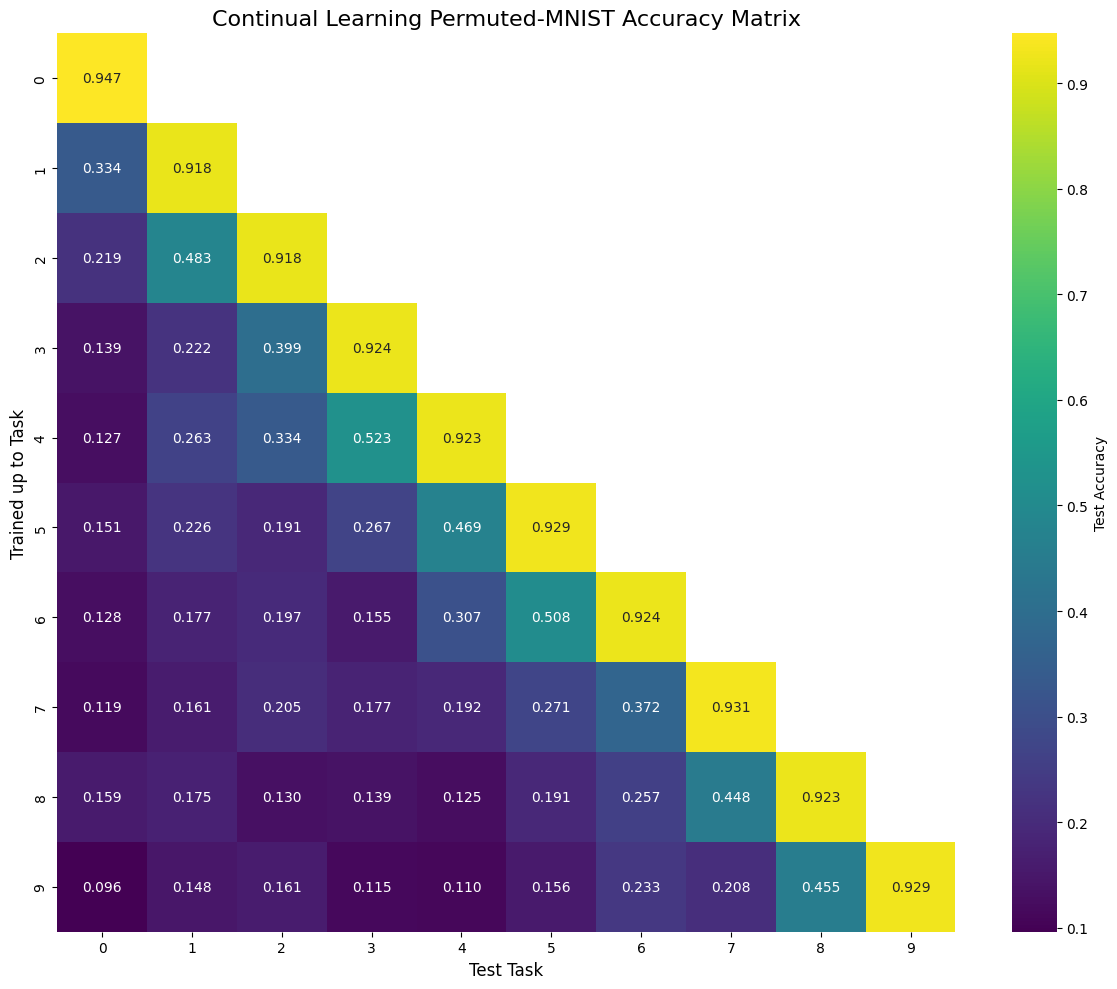

In [41]:
import seaborn as sns
# ヒートマップ用のピボットテーブルを作成
df = import_csv_file("/work/csv/DIL/random_baseline.csv")
acc_matrix= parse_triangle_accuracy(df)
print(acc_matrix) 

num_tasks = len(acc_matrix)
full_matrix = np.full((num_tasks, num_tasks), np.nan)

for i in range(num_tasks):
    for j in range(i + 1):  # 下三角部分
        full_matrix[i][j] = acc_matrix[i][j]

# heatmap用にDataFrameに変換
df_matrix = pd.DataFrame(full_matrix)
# ヒートマップの描画
plt.figure(figsize=(12, 10))
sns.heatmap(df_matrix, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Test Accuracy'})
plt.title('Continual Learning Permuted-MNIST Accuracy Matrix', fontsize=16)
plt.xlabel('Test Task', fontsize=12)
plt.ylabel('Trained up to Task', fontsize=12)
plt.tight_layout()
plt.show()

✅ データファイル '/work/csv/DIL/random_baseline.csv' を正常に読み込みました。


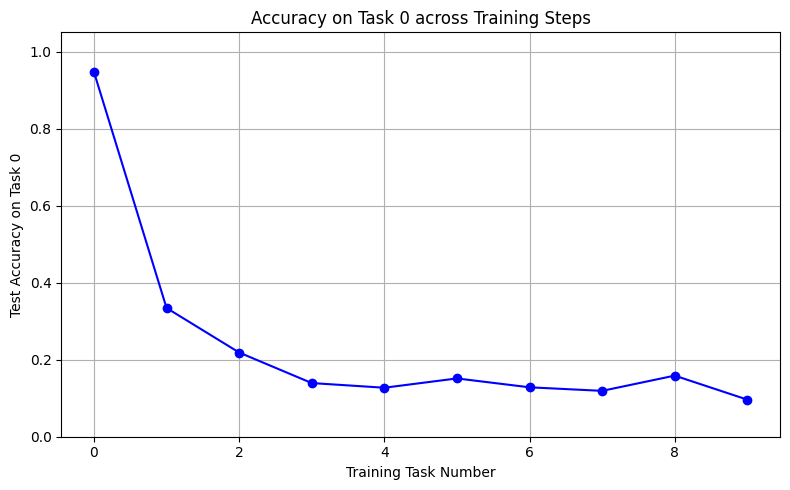

In [30]:
import matplotlib.pyplot as plt

# データ読み込みと変換（既に完了している前提）
df = import_csv_file("/work/csv/DIL/random_baseline.csv")
acc_matrix = parse_triangle_accuracy(df)

# Task0に対する精度（acc_matrix の各行の最初の要素）を抽出
task0_acc = [row[0] for row in acc_matrix if len(row) > 0]

# 折れ線グラフを描画
plt.figure(figsize=(8, 5))
plt.plot(range(len(task0_acc)), task0_acc, marker='o', linestyle='-', color='blue')
plt.title("Accuracy on Task 0 across Continual Learning Tasks")
plt.xlabel("Training Task Number")
plt.ylabel("Test Accuracy on Task 0")
plt.ylim(0, 1.05)  # 精度の範囲を明示
plt.grid(True)
plt.tight_layout()
plt.show()



警告: モデル 'RNN' のデータ数 (16) とノイズレベルの数 (11) が一致しません。
警告: モデル 'CNN' のデータ数 (16) とノイズレベルの数 (11) が一致しません。
警告: モデル 'LSTM' のデータ数 (16) とノイズレベルの数 (11) が一致しません。
警告: モデル 'NCPS' のデータ数 (16) とノイズレベルの数 (11) が一致しません。
--- 読み込みデータ ---
   Model  Noise Level  Test Accuracy
0    RNN          0.0       0.899286
1    RNN          0.1       0.904643
2    RNN          0.2       0.904286
3    RNN          0.3       0.900357
4    RNN          0.4       0.894643
5    RNN          0.5       0.875000
6    RNN          0.6       0.778571
7    RNN          0.7       0.695357
8    RNN          0.8       0.675714
9    RNN          0.9       0.660357
10   RNN          1.0       0.645714
11   CNN          0.0       0.906071
12   CNN          0.1       0.902857
13   CNN          0.2       0.897857
14   CNN          0.3       0.898571
15   CNN          0.4       0.902500
16   CNN          0.5       0.900357
17   CNN          0.6       0.886071
18   CNN          0.7       0.830357
19   CNN          0.8       0.746071
20   CNN 

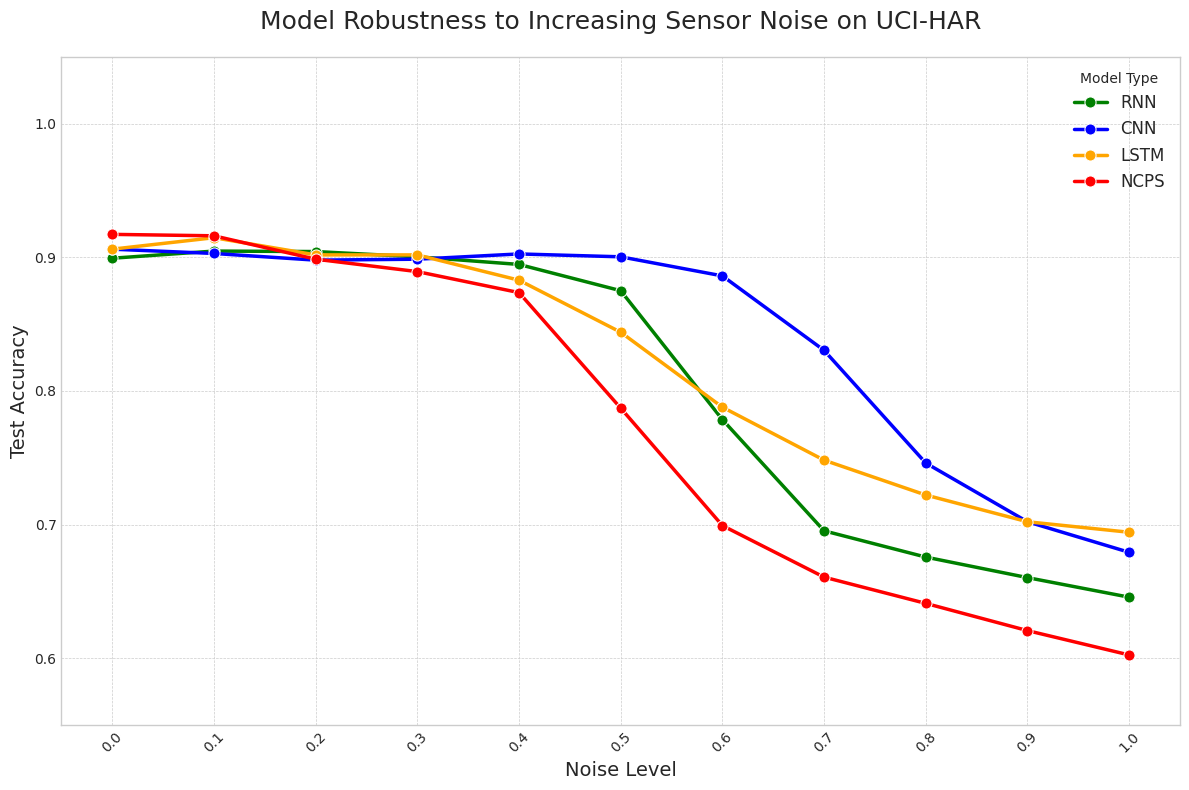

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. 設定 ---

# 各モデルのCSVファイルが置かれているディレクトリ
csv_directory = "/work/csv/uci-har/base/sensor_6/"

# グラフにプロットしたいモデルと、そのファイル名、グラフでの表示名を指定
models_to_plot = {
    "RNN": "rnn.csv",
    "CNN": "cnn.csv",
    "LSTM": "lstm.csv",
    "NCPS": "ltc_ncps.csv"
}

# 横軸となるノイズレベルを定義
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# --- ★★★ ここからが変更点 ★★★ ---
# 各モデルに割り当てる色を定義する辞書
color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "NCPS": "red",
    "LSTM": "orange"
}
# --- ★★★ 変更点ここまで ★★★ ---


# --- 2. データの読み込みと結合 ---

all_results = []

for model_name, file_name in models_to_plot.items():
    file_path = os.path.join(csv_directory, file_name)
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        accuracies = df['テスト精度 (Test Acc)'].values
        
        if len(accuracies) != len(noise_levels):
            print(f"警告: モデル '{model_name}' のデータ数 ({len(accuracies)}) とノイズレベルの数 ({len(noise_levels)}) が一致しません。")
            min_len = min(len(accuracies), len(noise_levels))
            accuracies = accuracies[:min_len]
            current_noise_levels = noise_levels[:min_len]
        else:
            current_noise_levels = noise_levels

        for noise, acc in zip(current_noise_levels, accuracies):
            all_results.append({
                "Model": model_name,
                "Noise Level": noise,
                "Test Accuracy": acc
            })
    else:
        print(f"警告: ファイルが見つかりません: {file_path}")

results_df = pd.DataFrame(all_results)
print("--- 読み込みデータ ---")
print(results_df)

# --- 3. グラフの描画 ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# Seabornを使って、モデルごとに色分けされた折れ線グラフを描画
ax = sns.lineplot(
    data=results_df,
    x="Noise Level",
    y="Test Accuracy",
    hue="Model",
    palette=color_palette, # <<<--- ★★★ ここで定義したカラーパレットを指定 ★★★
    marker="o",
    linewidth=2.5,
    markersize=8
)

# グラフの装飾
ax.set_title("Model Robustness to Increasing Sensor Noise on UCI-HAR", fontsize=18, pad=20)
ax.set_xlabel("Noise Level", fontsize=14)
ax.set_ylabel("Test Accuracy", fontsize=14)
ax.legend(title="Model Type", fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.ylim(0.55, 1.05)
plt.xticks(noise_levels, rotation=45) 
plt.tight_layout()
plt.show()